# ch14-16 基于scanpy

## PCA

[scanpy官方教程](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)

[单细胞转录组数据分析|| scanpy教程：预处理与聚类](https://www.jianshu.com/p/4ff1c74f0929)

[scanpy用于单细胞的降维聚类分析](https://www.jianshu.com/p/c10da146183d)

[（未测试）单细胞数据scanpy-学习笔记](http://www.weinformatics.cn/%EF%BC%88%E6%9C%AA%E6%B5%8B%E8%AF%95%EF%BC%89%E5%8D%95%E7%BB%86%E8%83%9E%E6%95%B0%E6%8D%AEscanpy-%E5%AD%A6%E4%B9%A0%E7%AC%94%E8%AE%B0/)

[scanpy分析单细胞数据](https://www.jianshu.com/p/24e1b2e823d2)

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

设置格式，读取数据

In [2]:
# 输出版本号
sc.logging.print_versions()
# 1,2,3表示输出结果详细程度，3最高
sc.settings.verbosity = 3
# 图片显示分辨率
sc.settings.set_figure_params(dpi=80)

D:\Anaconda3\lib\site-packages\umap\spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


scanpy==1.5.1 anndata==0.7.3 umap==0.4.3 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.1 statsmodels==0.11.1


In [3]:
# 设置结果文件保存路径
results_file = r'D:\JWE\Files\Courses\数据挖掘\work\第十四、十五、十六章\pbmc3k.h5ad'

# 导入 10X 数据
adata = sc.read_10x_mtx(
    r'D:\JWE\Files\Courses\数据挖掘\work\第十四、十五、十六章\data\pbmc3k_filtered_gene_bc_matrices\filtered_gene_bc_matrices\hg19', # 包含有 `.mtx` 文件的目录
    var_names='gene_symbols',                  # 用 gene symbols 作为变量名 (variables-axis index)
    cache=True)                                # 使用缓存文件加快读取

... reading from cache file cache\D-JWE-Files-Courses-数据挖掘-work-第十四、十五、十六章-data-pbmc3k_filtered_gene_bc_matrices-filtered_gene_bc_matrices-hg19-matrix.h5ad


•adata.X 存储 count matrix，数据类型为稀疏矩阵 scipy.sparse.csr.csr_matrix

•adata.obs 存储关于 obervations(cells) 的 metadata，数据类型为 dataframe

•adata.var 存储关于 variables(genes) 的 metadata，数据类型为 dataframe

•AnnData.uns 存储后续附加的其他非结构化信息

•adata.obs_names 和 adata.var_names index

AAACATACAACCAC 细胞

AL627309 基因

In [4]:
adata
# print(adata.X)
# adata.obs
# adata.var
# adata.var_names
# adata.obs_names
adata.uns

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

OverloadedDict, wrapping:
	OrderedDict()
With overloaded keys:
	['neighbors'].

In [5]:
# 索引去重
adata.var_names_make_unique()

In [6]:
adata
data1 = adata.X

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


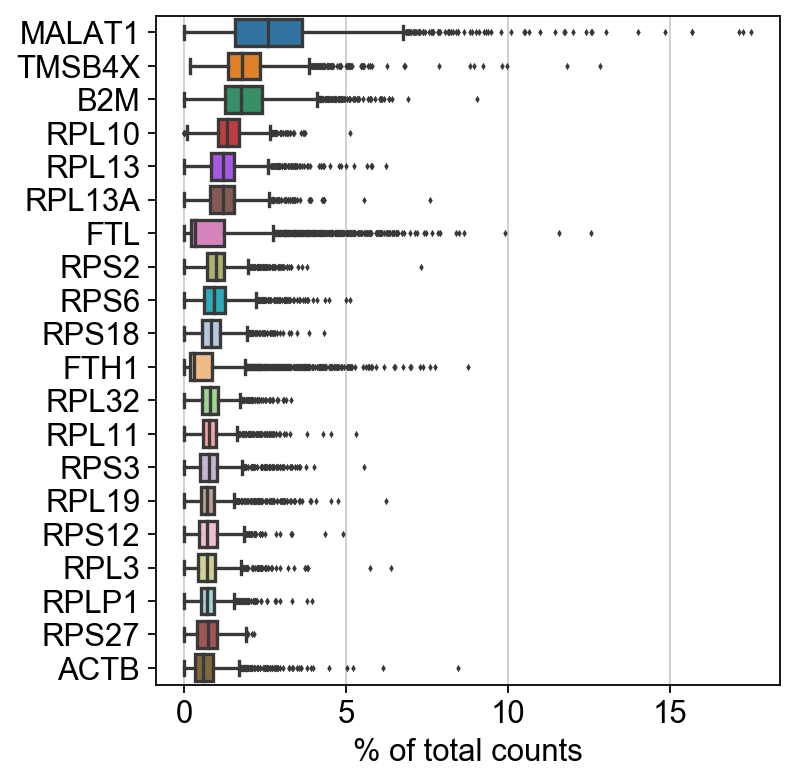

In [7]:
# 可视化所有细胞中计数最多的基因
sc.pl.highest_expr_genes(adata, n_top=20, )

In [8]:
# 保留至少在三个细胞中表达的基因，保留至少包含 200 个基因的细胞
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [9]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [10]:
mito_genes = adata.var_names.str.startswith('MT-')
# 计算每个细胞中的线粒体基因比例
# 使用`.A1` 将 numpy.matrix 转为一维数组 ndarray
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# 把每个细胞的基因计数添加到 adata 中
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

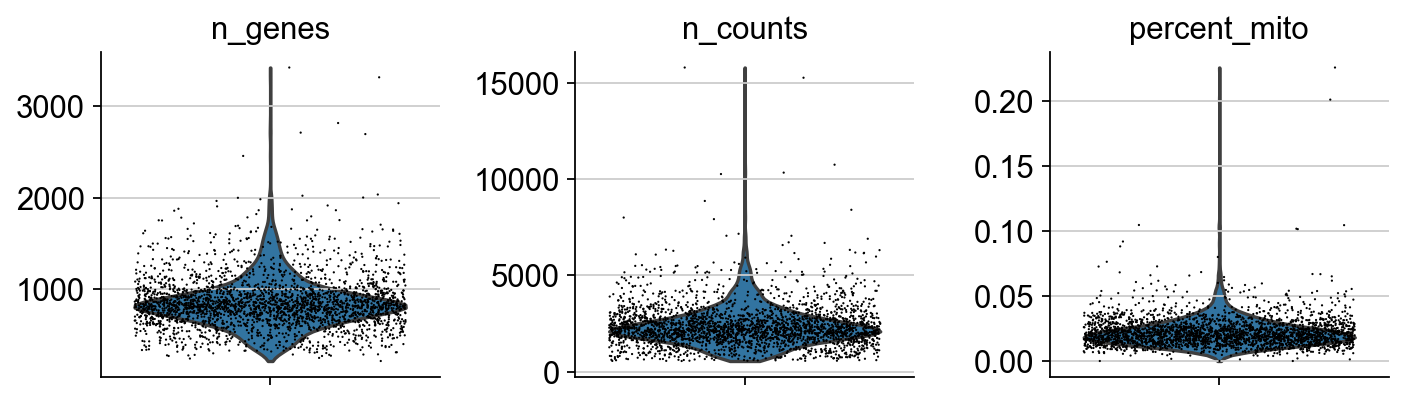

In [11]:
# 作小提琴图，查看线粒体基因占比分布
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

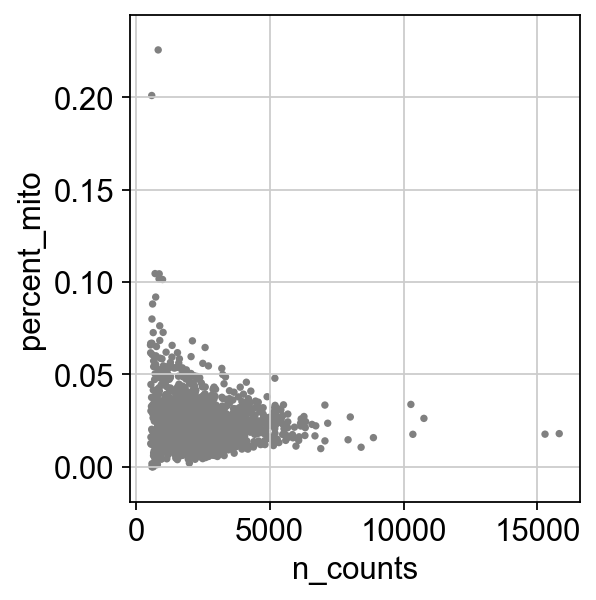

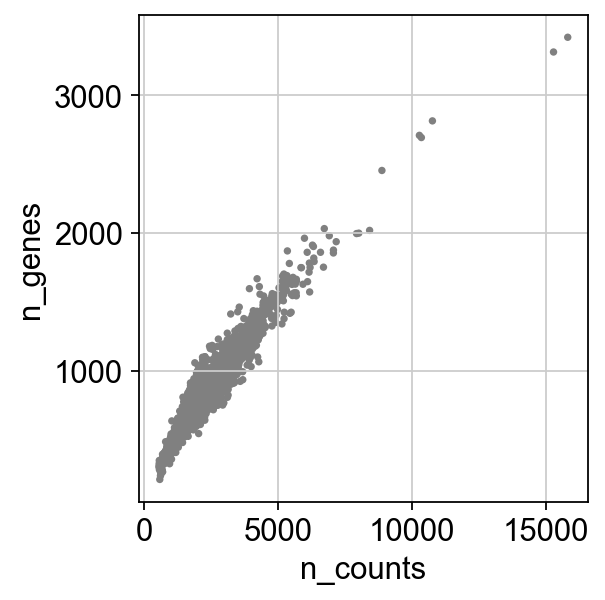

In [12]:
# 可视化特征之间关系
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [13]:
# 过滤线粒体基因比例 > 5% 和基因总数 > 2500 的细胞
adata = adata[adata.obs.n_genes < 2500, :]
adata = adata[adata.obs.percent_mito < 0.05, :]

In [14]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

数据标准化

In [15]:
# 数据标准化
sc.pp.normalize_total(adata, target_sum=1e4)
# 变化为自然对数
sc.pp.log1p(adata)
# 将AnnData对象的 .raw 属性设置为经归一化和对数化的原始基因表达值，供之后的可视化分析使用
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)


D:\Anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


n_genes:细胞中含有基因总数

percent_mito:细胞中线粒体基因比例

n_counts:细胞中的基因计数

n_cells:基因在细胞中有表达的个数

loglp:归一化和对数化的基因表达值

In [16]:
adata
print(adata.raw)
adata.obs
adata.var

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'
    uns: 'log1p'

Raw AnnData with n_obs × n_vars = 2638 × 13714
    var: 'gene_ids', 'n_cells'


,n_genes,percent_mito,n_counts
AAACATACAACCAC-1,781,0.030178,2419.0
AAACATTGAGCTAC-1,1352,0.037936,4903.0
AAACATTGATCAGC-1,1131,0.008897,3147.0
AAACCGTGCTTCCG-1,960,0.017431,2639.0
AAACCGTGTATGCG-1,522,0.012245,980.0
...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0
TTTCTACTGAGGCA-1,1227,0.009294,3443.0
TTTCTACTTCCTCG-1,622,0.021971,1684.0
TTTGCATGAGAGGC-1,454,0.020548,1022.0


,gene_ids,n_cells
AL627309.1,ENSG00000237683,9
AP006222.2,ENSG00000228463,3
RP11-206L10.2,ENSG00000228327,5
RP11-206L10.9,ENSG00000237491,3
LINC00115,ENSG00000225880,18
...,...,...
AC145212.1,ENSG00000215750,16
AL592183.1,ENSG00000220023,323
AL354822.1,ENSG00000215615,8
PNRC2-1,ENSG00000215700,110


选择差异基因

In [17]:
# 这一步在 adata.var 中添加了四列内容（highly_variable，means，dispersions，dispersions_norm）
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(adata)
# 取出高度差异的基因
adata = adata[:, adata.var.highly_variable]
# 校正细胞基因计数和线粒体基因比例的影响
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:13)


```python
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
```
这一步回归每个细胞总计数和线粒体基因表达百分比的影响。将数据放缩到方差为1。单细胞数据集可能包含“不感兴趣”的变异来源。这不仅包括技术噪音，还包括批次效应，甚至包括生物变异来源（细胞周期阶段）。正如(Buettner, et al NBT，2015)中所建议的那样，从分析中回归这些信号可以改善下游维数减少和聚类。

In [18]:
adata
adata.X

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

array([[-7.2785571e-02, -1.2929051e-01, -5.5762618e-03, ...,
        -1.7002191e-02, -8.3626725e-02, -4.0517688e-01],
       [-9.1086105e-02, -1.7157559e-01, -6.5472340e-03, ...,
        -4.6168588e-02, -1.2524137e-01, -4.5509979e-01],
       [-1.5998162e-01, -1.3586169e-01, -6.8725464e-03, ...,
        -2.7450195e-02, -6.8341322e-02,  1.0518360e+00],
       ...,
       [-8.7905586e-02, -1.1531777e-01, -5.5428366e-03, ...,
        -8.8488339e-03, -6.4416990e-02,  1.5571578e+00],
       [-8.0790803e-02, -1.0420774e-01, -5.2564032e-03, ...,
        -1.0238710e-03, -5.4077893e-02, -3.6773160e-01],
       [-1.4168720e-01, -1.1675589e-01, -6.2976936e-03, ...,
        -1.3568762e-02, -5.2123811e-02, -3.5951430e-01]], dtype=float32)

In [19]:
# 数据缩放
sc.pp.scale(adata, max_value=10)

In [20]:
adata
adata.X
adata.X.shape
# 备份
data0 = adata.X

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p'

array([[-0.17146961, -0.28081226, -0.04667677, ..., -0.09826882,
        -0.20909512, -0.5312033 ],
       [-0.21458235, -0.37265328, -0.05480441, ..., -0.266844  ,
        -0.31314582, -0.5966543 ],
       [-0.3768877 , -0.29508454, -0.05752748, ..., -0.15865593,
        -0.17087644,  1.3789997 ],
       ...,
       [-0.20708963, -0.2504642 , -0.04639699, ..., -0.05114426,
        -0.16106428,  2.041497  ],
       [-0.1903285 , -0.2263338 , -0.04399936, ..., -0.00591774,
        -0.13521305, -0.48211104],
       [-0.33378938, -0.25358772, -0.05271561, ..., -0.07842438,
        -0.13032718, -0.47133783]], dtype=float32)

(2638, 1838)

PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


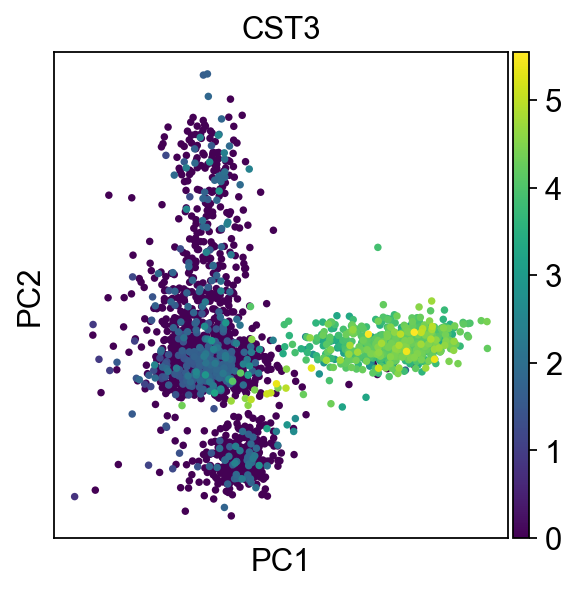

In [21]:
# svd_solver 指定奇异值分解 SVD 的方法
sc.tl.pca(adata, svd_solver='arpack')
# 绘图
sc.pl.pca(adata, color='CST3')

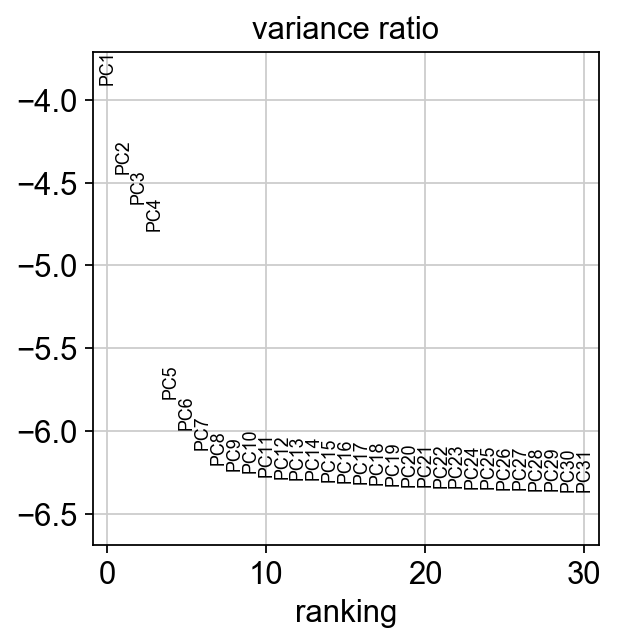

In [22]:
# 绘制碎石图，确定数据维度
sc.pl.pca_variance_ratio(adata, log=True)

In [23]:
adata
adata.X
# 主成分个数，第二维
adata.obsm['X_pca'].shape
# 累计方差贡献率
sum(adata.uns['pca']['variance_ratio'])

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

array([[-0.17146961, -0.28081226, -0.04667677, ..., -0.09826882,
        -0.20909512, -0.5312033 ],
       [-0.21458235, -0.37265328, -0.05480441, ..., -0.266844  ,
        -0.31314582, -0.5966543 ],
       [-0.3768877 , -0.29508454, -0.05752748, ..., -0.15865593,
        -0.17087644,  1.3789997 ],
       ...,
       [-0.20708963, -0.2504642 , -0.04639699, ..., -0.05114426,
        -0.16106428,  2.041497  ],
       [-0.1903285 , -0.2263338 , -0.04399936, ..., -0.00591774,
        -0.13521305, -0.48211104],
       [-0.33378938, -0.25358772, -0.05271561, ..., -0.07842438,
        -0.13032718, -0.47133783]], dtype=float32)

(2638, 50)

0.13271510496269912

In [24]:
# 保存结果
adata.write(results_file)

数据处理基本照搬教程。

**尝试用sklearn做一遍PCA**

[sklearn中PCA的使用方法](https://www.jianshu.com/p/8642d5ea5389)

In [25]:
from sklearn.decomposition import PCA

In [26]:
# data0 # 标准化后的数据
data0.shape

(2638, 1838)

In [27]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(data0)

pca1 = PCA(n_components=500)
X_pca1 = pca1.fit_transform(data0)

pca2 = PCA(n_components=1000)
X_pca2 = pca2.fit_transform(data0)

In [28]:
# 方差贡献率
# pca.explained_variance_ratio_
# 累计方差贡献率
sum(pca.explained_variance_ratio_) # 50
sum(pca1.explained_variance_ratio_) # 500
sum(pca2.explained_variance_ratio_) # 1000

0.13026979903224856

0.6262349222088233

0.8895882127981167

跟scanpy的结果差不多，50个主成分时累计方差贡献率不算高。

## TSNE

[sklearn中tsne可视化](https://www.deeplearn.me/2137.html)

[python--sklearn,聚类结果可视化工具TSNE](https://www.cnblogs.com/cygalaxy/p/6934197.html)

In [29]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [30]:
data1.shape # 原始的
data0.shape # 标准化的

(2700, 32738)

(2638, 1838)

In [31]:
tsne = TSNE(n_components=2,init='pca') # 降至二维
Y = tsne.fit_transform(data0)

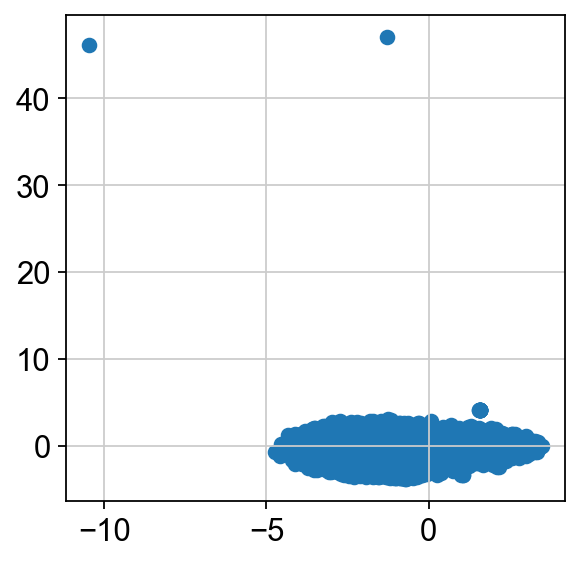

In [32]:
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
 
plt.show()

In [33]:
tsne3 = TSNE(n_components=3,init='pca') 
Y1 = tsne3.fit_transform(data0)

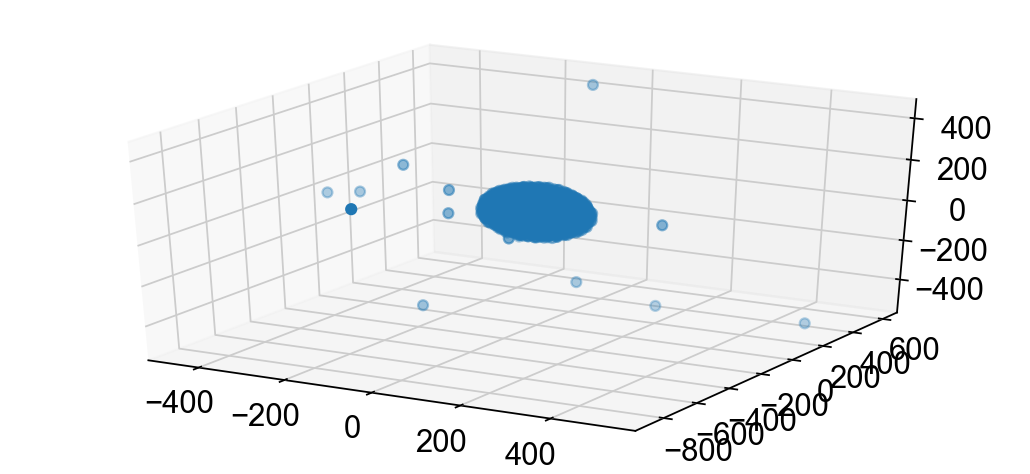

In [34]:
# X = make_s_curve(2638)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(211, projection='3d')
ax.scatter(Y1[:, 0], Y1[:, 1], Y1[:, 2], cmap=plt.cm.Spectral)

plt.show()

## Deep Auto-encoder

[Keras上实现AutoEncoder自编码器](https://blog.csdn.net/marsjhao/article/details/68928486)

[Keras实现autoencoder](https://www.cnblogs.com/yangmang/p/7530463.html)

[keras_Autoencoder 自编码](https://www.jianshu.com/p/e08b4445a4e0)

In [35]:
from keras.layers import Dense, Input
from keras.models import Model

Using TensorFlow backend.


In [36]:
# 加噪
data0_noisy = data0 + 0.005 * np.random.normal(loc=0., scale=1., size=data0.shape)

In [37]:
input_data = Input(shape=(data0.shape[0],))
# input_data = Input(shape=data0.shape)


# 编码层
encoded = Dense(1000, activation='relu')(input_data)
encoded = Dense(300, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)
encoder_output = Dense(2)(encoded)
 
# 解码层
decoded = Dense(10, activation='relu')(encoder_output)
decoded = Dense(300, activation='relu')(decoded)
decoded = Dense(1000, activation='relu')(decoded)
decoded = Dense(data0.shape[0], activation='sigmoid')(decoded)

autoencoder = Model(input=input_data, output=decoded)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [38]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2638)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2639000   
_________________________________________________________________
dense_2 (Dense)              (None, 300)               300300    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                3010      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_6 (Dense)              (None, 300)               3300

In [39]:
# autoencoder.fit(data0.T,data0.T, epochs=10, batch_size=300, shuffle=True)
autoencoder.fit(data0_noisy.T,data0.T, epochs=10, batch_size=300, shuffle=True)

Epoch 1/10
1838/1838 [==============================] - 2s 1ms/step - loss: 1.0731
Epoch 2/10
1838/1838 [==============================] - 2s 1ms/step - loss: 0.8683
Epoch 3/10
1838/1838 [==============================] - 2s 887us/step - loss: 0.8676
Epoch 4/10
1838/1838 [==============================] - 2s 909us/step - loss: 0.8679
Epoch 5/10
1838/1838 [==============================] - 2s 871us/step - loss: 0.8678
Epoch 6/10
1838/1838 [==============================] - 2s 833us/step - loss: 0.8678
Epoch 7/10
1838/1838 [==============================] - 2s 838us/step - loss: 0.8678
Epoch 8/10
1838/1838 [==============================] - 2s 840us/step - loss: 0.8678
Epoch 9/10
1838/1838 [==============================] - 2s 830us/step - loss: 0.8678
Epoch 10/10
1838/1838 [==============================] - 2s 837us/step - loss: 0.8678


In [40]:
result = autoencoder.predict(data0.T)

In [41]:
result[:3,:]

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.1122760e-35, 4.0490405e-29, 1.6332079e-32, ..., 6.0653327e-30,
        4.2974881e-30, 4.8121826e-32]], dtype=float32)